# Dataset Verona Card

Struttura del file contenete i dati delle strisciate della verona card:

|campo  | label	| descrizione	|
|-----|-----|-------------------|
|0	| attivazione	| data di attivazione della verona card	|
|1	| id_vc	| codice identificativo della verona card	|
|2	| istante	| data ed ora di utilizzo della verona card|
|3  | profilo | formato della verona card (validità 24 o 72 ore)|
|4	| poi	| codice del punto di interesse in cui è stata utilizzata	|
|5	| classid	| identificativo della strisciata iniviato dal server per la raccolta dei dati	|

Load dei dati:

In [1]:
base_dir = 'dataset/'

filename_vc = base_dir + 'veronaCard.csv'
file_vc = sc.textFile(filename_vc)

header = file_vc.first()

data_vc = file_vc.filter(lambda row: row != header)\
                    .map(lambda row : row.split(","))\
                    .filter(lambda x: x[0].split('-')[0] != '2020')\
                    .map(lambda x: (x[0], x[1], x[2], x[4]))

# data, id_vc, istante, poi
#('2017-11-29', '0435803A9C4C81', '29/11/2017 12:07', '61')

data_vc.persist()

data_vc.take(5)

22/05/26 14:28:47 WARN BlockManager: Task 1 already completed, not releasing lock for rdd_3_0


[('2017-11-29', '0435803A9C4C81', '29/11/2017 12:07', '61'),
 ('2017-11-29', '04CF813A9C4C80', '29/11/2017 12:07', '61'),
 ('2017-10-05', '04B28C4A9C4C80', '05/10/2017 12:19', '61'),
 ('2017-10-05', '04E279429C4C80', '05/10/2017 12:16', '61'),
 ('2017-12-28', '040F9D429C4C80', '28/12/2017 11:06', '61')]

**ESEMPIO**: dati 2020 non hanno un idenitficativo univoco per la VC

In [2]:
file_vc.filter(lambda row: row != header)\
        .map(lambda row : row.split(","))\
        .filter(lambda x: x[0].split('-')[0] == '2020')\
        .take(10)

[['2020-11-01', '25', '01/11/2020 17:07', 'vrcard-48-2019', '49', '2378559'],
 ['2020-11-01', '25', '01/11/2020 17:07', 'vrcard-48-2019', '49', '2378560'],
 ['2020-11-01', '25', '01/11/2020 14:22', 'vrcard-24-2019', '49', '2378561'],
 ['2020-11-01', '25', '01/11/2020 14:22', 'vrcard-24-2019', '49', '2378562'],
 ['2020-07-07', '25', '07/07/2020 11:44', 'vrcard-48-2019', '49', '2378563'],
 ['2020-02-23', '25', '23/02/2020 16:19', 'vrcard-24-2019', '49', '2378564'],
 ['2020-02-23', '25', '23/02/2020 16:19', 'vrcard-24-2019', '49', '2378565'],
 ['2020-02-23', '25', '23/02/2020 10:49', 'vrcard-24-2019', '49', '2378566'],
 ['2020-02-19', '25', '19/02/2020 13:19', 'vrcard-48-2019', '49', '2378567'],
 ['2020-02-12', '25', '12/02/2020 15:16', 'vrcard-48-2019', '49', '2378568']]

### Q1
###### Per ogni Verona Card, il numero di punti di interesse (Points of Interest, PoI) visitati, da cui costruire la sua distribuzione (l'asse x contiene il numero di PoI, l'asse Y la percentuale di Verona Card usate per quel numero di PoI);

Controllo che tutti gli identificativi siano univoci: verifico se il numero di VC considerando come chiave _id\_vc_ e come chiave (_id\_vc_, _attivazione_) coincide

In [3]:
no_attivazione = data_vc.map(lambda x: (x[1])).distinct().count()
si_attivazione  = data_vc.map(lambda x: (x[1],x[0])).distinct().count()

print('Gli id_vc sono univoci? ')
if no_attivazione == si_attivazione:
      print('True')
else:
      print('\tNO\ncon attivazione:',si_attivazione, '\nsenza attivazione:',no_attivazione)

Gli id_vc sono univoci? 
	NO
con attivazione: 671026 
senza attivazione: 482801


In [4]:
visit_vc = data_vc.map(lambda x: ((x[1],x[0]), 1))\
                .reduceByKey(lambda a,b: a+b)

#visit_vc = per ogni verona card il numero di poi visitati

visit_vc.take(5)

[(('04C5653A9C4C80', '2017-10-05'), 5),
 (('045F673A9C4C80', '2017-10-05'), 5),
 (('04039E429C4C81', '2017-12-28'), 6),
 (('04C58A429C4C80', '2017-10-31'), 4),
 (('04B30A429C4C84', '2017-11-29'), 6)]

In [5]:
tot_vc = visit_vc.count() #numero totale di verona card

visit_vc_same = visit_vc.map(lambda x: (x[1],1))\
                        .reduceByKey(lambda a,b: a+b)\
                        .map(lambda x: (x[0],x[1]/tot_vc * 100))\
                        .sortByKey()\
                        .collect()

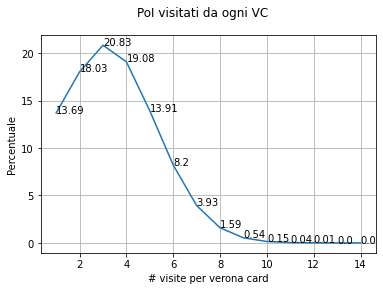

In [6]:
import matplotlib.pyplot as plt

perc_vc = [ x[1] for x in visit_vc_same]
visit_number = [x[0] for x in visit_vc_same]

plt.suptitle('PoI visitati da ogni VC')
plt.xlabel('# visite per verona card')
plt.ylabel('Percentuale')

plt.grid(ls = '-')
plt.plot(visit_number, perc_vc)
for x,y in zip(visit_number, perc_vc):
    plt.text(x,y, str(round(y,2)))

plt.show()

### Q2
###### Per ogni PoI, la distribuzione del numero di visite giornaliere (l'asse x indica il range di visitatori, l'asse y la percentuali di giorni che quel PoI ha ricevuto un numero di visitatori all'interno di quel range);

Creo la funzione per la suddivisione in bucket di affluenza

In [7]:
number_bucket = 15
def getBucket(visitors, max_v, min_v):
    if max_v == visitors:
        return number_bucket
    
    bucket = round((max_v - min_v) / number_bucket,0)
    return int((visitors - min_v) / bucket) + 1

In [9]:
daily_visitors = data_vc.map(lambda x: ((x[3],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)
daily_visitors.take(5)

[(('61', '19/11/2017'), 157),
 (('61', '04/10/2017'), 201),
 (('61', '27/11/2017'), 60),
 (('61', '25/10/2017'), 136),
 (('61', '24/10/2017'), 105)]

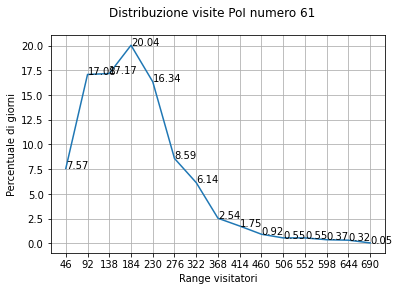

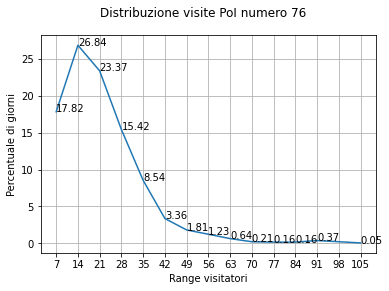

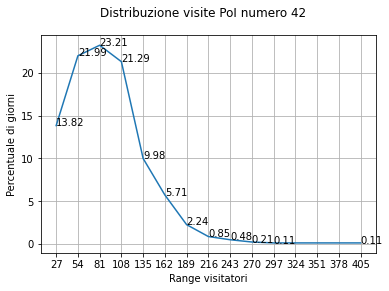

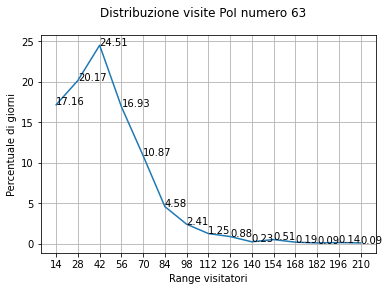

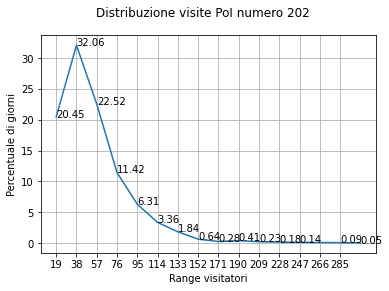

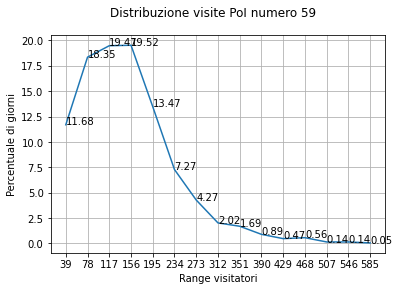

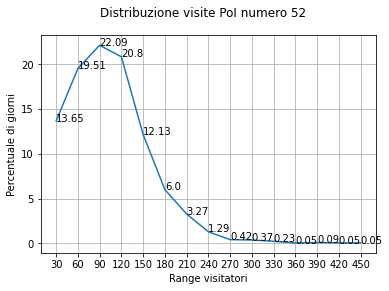

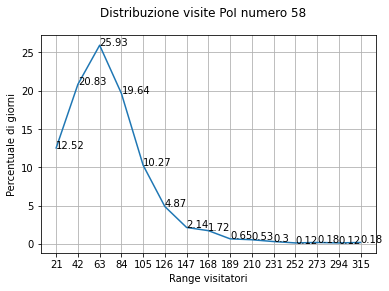

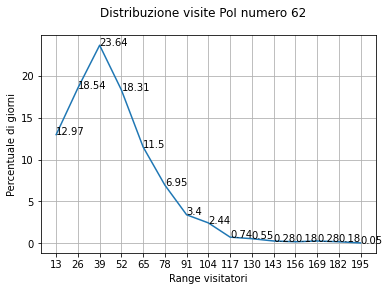

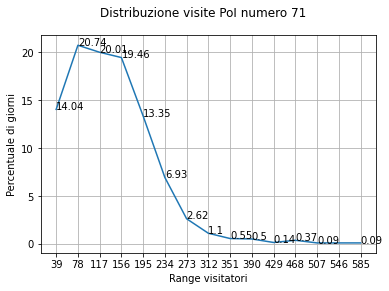

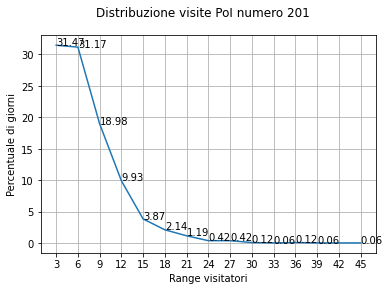

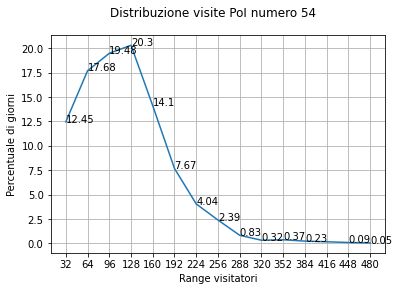

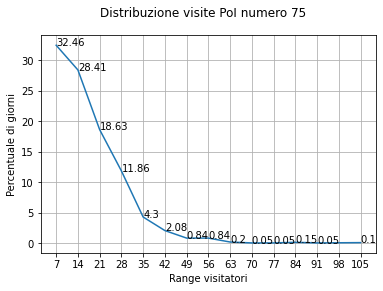

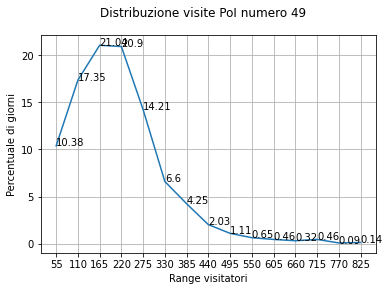

In [10]:
import matplotlib.pyplot as plt

list_poi = data_vc.map(lambda x: x[3]).distinct().collect()

for poi in list_poi:
    count_daily = daily_visitors.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: (x[0][1],x[1]))
    
    max_visitors = count_daily.map(lambda x: x[1]).max()
    min_visitors = count_daily.map(lambda x: x[1]).min()
    tot_visitors = count_daily.count()
    
    group_same_count_visitors = count_daily.map(lambda x: (getBucket(x[1],max_visitors,min_visitors), 1))\
                                            .reduceByKey(lambda a,b: a+b)\
                                            .map(lambda x: (x[0],x[1] / tot_visitors * 100))\
                                            .sortByKey()\
                                            .collect()

    bucket = max(int(max_visitors/number_bucket), 1)
    visitors = [ x[1] for x in group_same_count_visitors]
    bucket_list = [ x[0]*bucket  for x in group_same_count_visitors]
    
    x_labels = range(0, max_visitors,bucket)
    plt.xticks(x_labels)
    
    plt.suptitle('Distribuzione visite PoI numero {}'.format(poi))
    plt.xlabel('Range visitatori')
    plt.ylabel('Percentuale di giorni')
    plt.grid()
    plt.plot(bucket_list,visitors)
    for x,y in zip(bucket_list,visitors):
        plt.text(x,y, str(round(y,2)))
    plt.show()

------------------------------------------------------------
---------------------------------------------------------------

# Dataset Stazioni metereologiche

Struttura del file contenete i dati delle stazioni metereologiche di Verona:

|campo  | label	| descrizione	|
|-----|-----|-------------------|
|0	| data	| data del rilevamento	|
|1	| ora	| ora del rilevamento	|
|2	| t	| temperatura in gradi centigradi |
|3  | ur | |
|4	| pr	| pressione atmosferica	|
|5	| wind	| vento in km/h	|
|6	| wind_dir	| direzione del vento	|
|7	| rain	| millimetri di pioggia	|
|8	| dp	| 	|
|9	| idstazione | id della stazione metereologica da cui sono stati rilevati i dati	|

Load dei dati:

In [11]:
base_dir = 'dataset/'

filename_w = base_dir+"meteo.csv"
file_w = sc.textFile(filename_w)

# extract header
#header = rawData.first() 

# remove the header, separate the elements for each row
#data_weather = rawData.filter(lambda row: row != header).map(lambda row : row.split(",")) 
data_weather = file_w.map(lambda row : row.split(","))\
                .map(lambda x: (x[0],int(x[1][:2]),float(x[2]),float(x[7])))
    
data_w = data_weather.filter(lambda x: x[1] < 24)\
                     .filter(lambda x: x[3] > 0)\
                     .filter(lambda x: x[2] < 50 and x[2] > -20)

# data, ora, t, rain
#('2016-02-08', 11, 10.7, 10.3)

data_w.persist()

data_w.take(5)

22/05/26 14:38:58 WARN BlockManager: Task 645 already completed, not releasing lock for rdd_247_0


[('2016-02-08', 11, 10.7, 10.3),
 ('2016-02-08', 11, 9.0, 19.8),
 ('2016-02-08', 11, 8.7, 10.2),
 ('2016-02-08', 11, 8.5, 8.1),
 ('2016-02-08', 11, 9.6, 4.2)]

**ESEMPIO:** orari non validi

In [12]:
file_w.map(lambda row : row.split(","))\
    .map(lambda x: (x[0],x[1],float(x[2]),float(x[7])))\
    .filter(lambda x: int(x[1][:2]) >= 24)\
    .take(5)

[('2014-01-07', '33.21', 5.3, 0.0),
 ('2014-01-07', '53.21', 4.8, 0.0),
 ('2014-01-07', '33.22', 4.3, 0.0),
 ('2014-01-07', '54.22', 3.9, 0.0),
 ('2014-01-07', '33.23', 3.7, 0.0)]

**ESEMPIO:** millimetri di pioggia negativi, temperature anomale per Verona

In [13]:
file_w.map(lambda row : row.split(","))\
    .map(lambda x: (x[0],x[1],float(x[2]),float(x[7])))\
    .filter(lambda x: x[3]<0 or x[2]>50 or x[2]<-20)\
    .take(5)

[('2021-12-29', '09:48', 5.3, -35.4),
 ('2016-02-12', '18.26', 59.7, 0.0),
 ('2016-02-15', '00.04', 70.0, 0.0),
 ('2016-02-28', '17.46', 80.3, 2.5),
 ('2016-02-28', '18.06', 80.3, 3.0)]

### C1
###### Giorni in cui ha piovuto per almeno X ore / giorni in cui ha piovuto meno di X ore

Eseguita media dei millimetri di pioggia in un'ora

Assegnato 1 alla tupla se in quell'ora ha piovuto, 0 altrimenti

Somma delle ore di pioggia in un giorno

In [14]:
rain_hour = data_w.map(lambda x: ((x[0],x[1]),x[3]) )\
                .reduceByKey(lambda a,b : (a+b) / 2)
rain_hour.take(3)

[(('2021-12-01', 21), 0.9665251502514026),
 (('2021-12-03', 14), 0.24452092344878867),
 (('2021-12-18', 23), 0.24530944825310141)]

Viene già tolta l'ora per poter fare direttamente il reduceByKey sulla data

In [15]:
rain_hour = rain_hour.map(lambda x: (x[0][0], 1 if x[1]>0 else 0))

rain_hour.take(3)

[('2021-12-01', 1), ('2021-12-03', 1), ('2021-12-18', 1)]

In [16]:
rain_hour = rain_hour.reduceByKey(lambda a,b: a+b)

rain_hour.take(10)

[('2016-01-11', 24),
 ('2016-01-18', 24),
 ('2016-02-12', 24),
 ('2016-06-02', 24),
 ('2016-08-05', 24),
 ('2016-08-16', 24),
 ('2016-09-30', 24),
 ('2016-10-03', 24),
 ('2016-10-29', 24),
 ('2016-11-21', 24)]

In [17]:
mean_rain = round(rain_hour.map(lambda x: x[1]).mean(), 2)
print('Media delle ore di pioggia per giorno: ', mean_rain)

Media delle ore di pioggia per giorno:  20.94


Viene alzata la treshold per assegnare 0 o 1, rimando alla relazione per la spiegazione

In [18]:
rain_hour = data_w.map(lambda x: ((x[0],x[1]),x[3]) )\
                .reduceByKey(lambda a,b : (a+b) / 2)\
                .map(lambda x: (x[0][0], 1 if x[1]>=1 else 0))\
                .reduceByKey(lambda a,b: a+b)
rain_hour.take(10)

[('2016-01-11', 19),
 ('2016-01-18', 23),
 ('2016-02-12', 19),
 ('2016-06-02', 19),
 ('2016-08-05', 24),
 ('2016-08-16', 11),
 ('2016-09-30', 0),
 ('2016-10-03', 11),
 ('2016-10-29', 19),
 ('2016-11-21', 20)]

In [19]:
mean_rain = round(rain_hour.map(lambda x: x[1]).mean(), 2)
print('Media delle ore di pioggia per giorno: ', mean_rain)

Media delle ore di pioggia per giorno:  11.31


Definizione della funzione per la suddivisione in giorni in cui ha piovuto più di X ore / meno di X ore

Argomenti richiesti: X per la suddivisione e l'rdd

Ritorna: tupla con due rdd, uno contenente i giorni in cui ha piovuto meno di X ore, uno contenente i giorni in cui ha piovuto più di X ore

In [20]:
def splitRain(rdd, hour_rain):
    over_X = rdd.filter(lambda x: x[1] >= hour_rain)
    under_X = rdd.filter(lambda x: x[1] < hour_rain)
    
    return (over_X, under_X)

Esempio di esecuzione con X = media ore di pioggia giornaliere

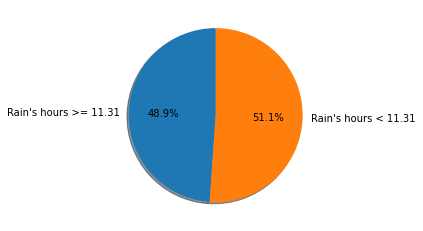

In [21]:
over_X, under_X = splitRain(rain_hour, mean_rain)

import matplotlib.pyplot as plt

labels = 'Rain\'s hours >= {}'.format(mean_rain), 'Rain\'s hours < {}'.format(mean_rain)
sizes = [over_X.count(),under_X.count()]

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

### C2
###### Giorni in cui la temperatura media era superiore a Y / giorni in cui era inferiore a Y

Calcolata la media della tempeeratura ogni ora

Calcolata la media delle temperatura giornaliera

In [23]:
temp_day = data_w.map(lambda x: ((x[0],x[1]),x[2]) )\
                .reduceByKey(lambda a,b : round((a + b)/2, 2))\
                .map(lambda x: (x[0][0],x[1]))\
                .reduceByKey(lambda a,b : round((a + b)/2, 2))

temp_day.take(3)

[('2016-01-11', 6.91), ('2016-01-18', 4.39), ('2016-02-12', 8.88)]

In [24]:
mean_temp = round(temp_day.map(lambda x: x[1]).mean(), 2)
print('Temperatura media giornaliera: ', mean_temp)

Temperatura media giornaliera:  11.97


Definizione della funzione per la suddivisione in giorni in cui c'è una temperatura media maggiore di Y / minore di Y

Argomenti richiesti: Y per la suddivisione e l'rdd

Ritorna: tupla con due rdd, uno contenente i giorni in cui c'è una temperatura media maggiore di Y, uno contenente i giorni in cui c'è una temperatura media minore di Y

In [25]:
def splitTemp(rdd, temp):
    over_Y = rdd.filter(lambda x: x[1] >= temp)
    under_Y = rdd.filter(lambda x: x[1] < temp)
    
    return (over_Y, under_Y)

Esempio di esecuzione con Y = temperatura media giornaliera

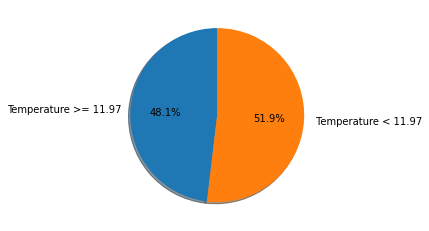

In [26]:
over_Y, under_Y = splitTemp(temp_day, mean_temp)

import matplotlib.pyplot as plt

labels = 'Temperature >= {}'.format(mean_temp), ' Temperature < {}'.format(mean_temp)
sizes = [over_Y.count(),under_Y.count()]

plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

# Utilizzo dataset Verona Card e Stazioni Metereologiche

## Discriminante ore di pioggia
##### Ricalcola Q1 e Q2 considerando la suddivisione in C1 (per alcuni valori di X scelti da te) e confronta le distribuzioni nei giorni in cui ha piovuto / non ha piovuto per X ore.

A causa dei formati della data differenti, definizione della funzione per standardizzarla.

Viene rimosso l'orario della strisciata della VC in quanto non rilevante

In [27]:
def getDate(date):
    day, month, year = date.split(' ')[0].split('/')
    return '-'.join([year, month, day])

print('Prima: ', data_vc.take(1))
data_vc = data_vc.map(lambda x: (x[0], x[1], getDate(x[2]), x[3]))
print('Dopo: ', data_vc.take(1))

Prima:  [('2017-11-29', '0435803A9C4C81', '29/11/2017 12:07', '61')]
Dopo:  [('2017-11-29', '0435803A9C4C81', '2017-11-29', '61')]


22/05/26 14:52:08 WARN BlockManager: Task 1191 already completed, not releasing lock for rdd_3_0
22/05/26 14:52:08 WARN BlockManager: Task 1192 already completed, not releasing lock for rdd_3_0


### Q1 + C1

La somma dei PoI visitati da ogni VC non è sulla durata della carta come in **Q1**, ma viene fatta sul numero di utilizzi giornalieri altrimenti non è possibile discriminare per giorni in cui ha piovuto più di X ore / giorni in cui ha piovuto meno di X ore

In [29]:
visit_vc = data_vc.map(lambda x: ((x[2],x[1]), 1))\
                .reduceByKey(lambda a,b: a+b)\
                .map(lambda x: (x[0][0],(x[0][1],x[1])))
visit_vc.take(5)

[('2017-10-05', ('04B28C4A9C4C80', 1)),
 ('2017-10-05', ('04E279429C4C80', 5)),
 ('2017-10-05', ('045F673A9C4C80', 5)),
 ('2017-11-29', ('04952C3A9C4C80', 6)),
 ('2017-10-30', ('0438A0429C4C80', 2))]

Suddivisione dei giorni, X = media ore di pioggia giornaliere

A seguito della suddivisione viene fatto il join sul giorno per suddividere le due distribuzioni

Viene caolcolata **Q1** analogamene a quanto fatto prima

In [30]:
over_X, under_X = splitRain(rain_hour, mean_rain)

visit_vc_over = visit_vc.join(over_X)\
                            .map(lambda x: x[1][0])

tot_vc_over = visit_vc_over.map(lambda x: x[0]).distinct().count()

list_over = visit_vc_over.map(lambda x: (x[1],1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0],x[1] / tot_vc_over * 100))\
                            .sortByKey()\
                            .collect()


visit_vc_under = visit_vc.join(under_X)\
                            .map(lambda x: x[1][0])

tot_vc_under = visit_vc_under.map(lambda x: x[0]).distinct().count()

list_under = visit_vc_under.map(lambda x: (x[1],1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0],x[1] / tot_vc_under * 100))\
                            .sortByKey()\
                            .collect()
                            

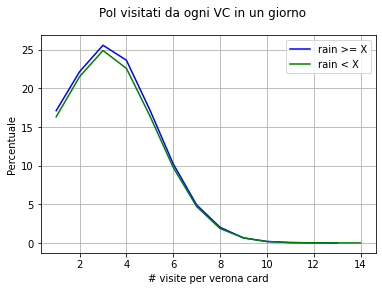

In [31]:
import matplotlib.pyplot as plt

perc_vc_over = [ x[1] for x in list_over]
perc_vc_under = [ x[1] for x in list_under]
visit_number_over = [x[0] for x in list_over]
visit_number_under = [x[0] for x in list_under]

plt.suptitle('PoI visitati da ogni VC in un giorno')
plt.xlabel('# visite per verona card')
plt.ylabel('Percentuale')

plt.grid(ls = '-')
plt.plot(visit_number_over,perc_vc_over, color='b', label= 'rain >= X')
plt.plot(visit_number_under,perc_vc_under, color='g', label= 'rain < X')
plt.legend()

plt.show()

### Q2 + C1

Per ogni giorno e per ogni PoI viene calcolato il numero di presenze come per **Q2**

Viene eseguito lo split in giorni secondo  X = media ore di pioggia giornaliere

Per ogni poi viene eseguito il join per suddividere le due distibuzioni che vengono calcolate analogamente a quanto visto in **Q2**

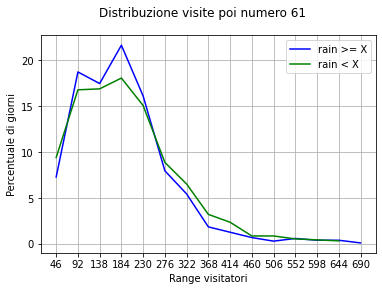

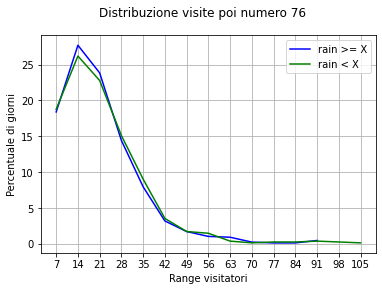

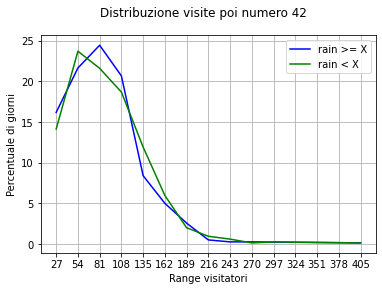

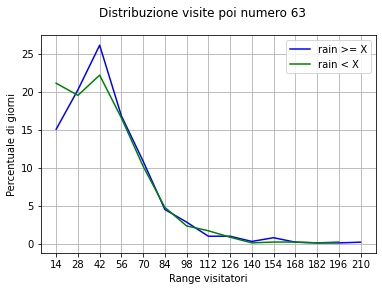

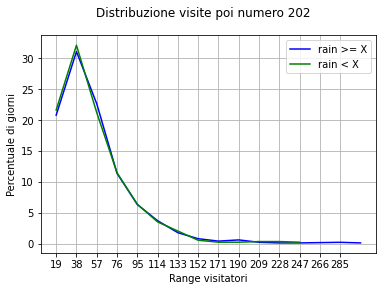

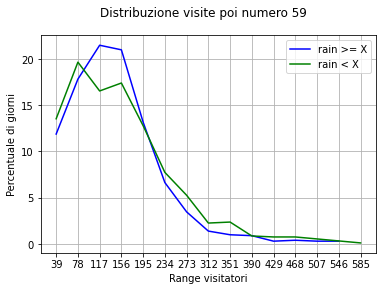

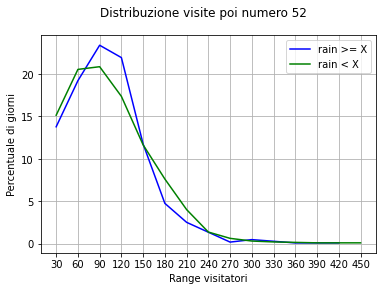

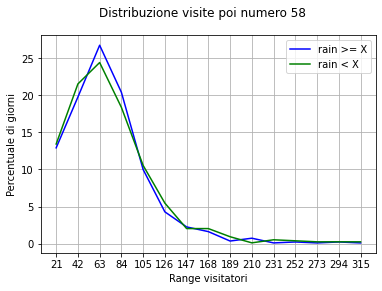

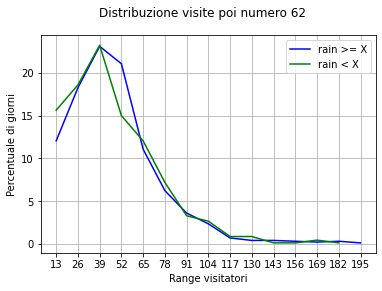

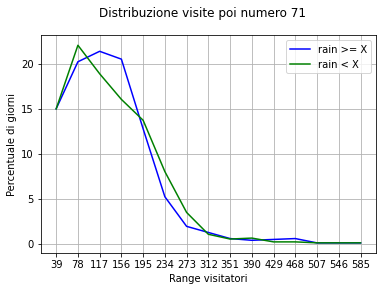

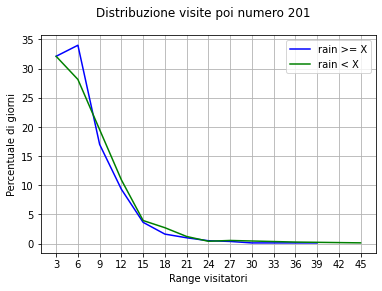

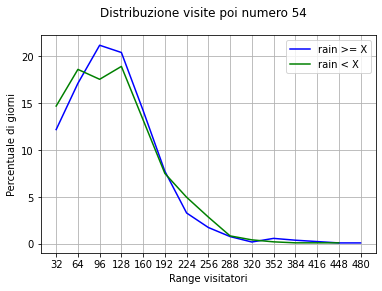

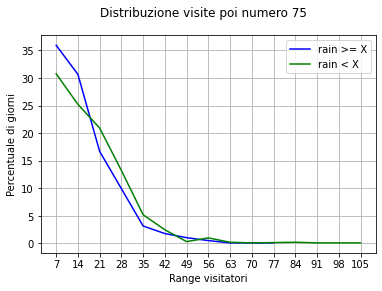

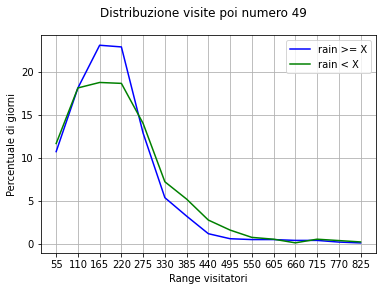

In [32]:
import matplotlib.pyplot as plt

list_poi = data_vc.map(lambda x: x[3]).distinct().collect()

daily_visitors = data_vc.map(lambda x: ((x[3],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)

over_X, under_X = splitRain(rain_hour, mean_rain)

for poi in list_poi:
    count_daily = daily_visitors.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: (x[0][1],x[1]))
    
    max_visitors = count_daily.map(lambda x: x[1]).max()
    min_visitors = count_daily.map(lambda x: x[1]).min()
    
    over_join = count_daily.join(over_X)
    under_join = count_daily.join(under_X)
    
    tot_days_over = over_join.count()
    tot_days_under = under_join.count()
    
    over_list = over_join.map(lambda x: (getBucket(x[1][0],max_visitors,min_visitors), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0], x[1] / tot_days_over * 100))\
                            .sortByKey()\
                            .collect()

    under_list = under_join.map(lambda x: (getBucket(x[1][0],max_visitors,min_visitors), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0], x[1] / tot_days_under * 100))\
                            .sortByKey()\
                            .collect()
    
    bucket = max(int(max_visitors/number_bucket), 1)
    
    visitors_over = [ x[1] for x in over_list]
    visitors_under = [ x[1] for x in under_list]
    bucket_over = [ x[0]*bucket  for x in over_list]
    bucket_under = [ x[0]*bucket  for x in under_list]

    x_labels = range(0, max_visitors,bucket)
    plt.xticks(x_labels)
    
    plt.suptitle('Distribuzione visite poi numero {}'.format(poi))
    plt.xlabel('Range visitatori')
    plt.ylabel('Percentuale di giorni')
    plt.grid()
    plt.plot(bucket_over,visitors_over,color='b',label= 'rain >= X')
    plt.plot(bucket_under,visitors_under,color='g',label= 'rain < X')
    plt.legend()
    plt.show()
    


## Discriminante temperatura media
##### Ricalcola Q1 e Q2 considerando la suddivisione in C2 (per alcuni valori di Y scelti da te) e confronta le distribuzioni nei giorni in cui la temperatura media era superiore a Y / giorni in cui era inferiore a Y

Interrogazioni analoghe a **Discriminate ore di pioggia** viene cambiata solo la funzione di suddivisione dei giorni

### Q1 + C2

In [33]:
visit_vc = data_vc.map(lambda x: ((x[2],x[1]), 1))\
                .reduceByKey(lambda a,b: a+b)\
                .map(lambda x: (x[0][0],(x[0][1],x[1])))

over_Y, under_Y = splitTemp(temp_day, mean_temp)

visit_vc_over = visit_vc.join(over_X)\
                            .map(lambda x: x[1][0])

tot_vc_over = visit_vc_over.map(lambda x: x[0]).distinct().count()

list_over = visit_vc_over.map(lambda x: (x[1],1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0],x[1] / tot_vc_over * 100))\
                            .sortByKey()\
                            .collect()


visit_vc_under = visit_vc.join(under_X)\
                            .map(lambda x: x[1][0])

tot_vc_under = visit_vc_under.map(lambda x: x[0]).distinct().count()

list_under = visit_vc_under.map(lambda x: (x[1],1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0],x[1] / tot_vc_under * 100))\
                            .sortByKey()\
                            .collect()

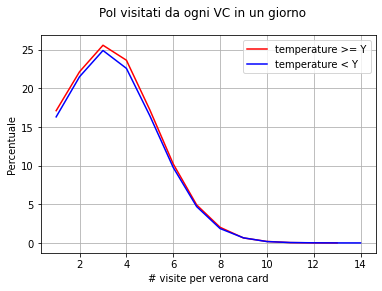

In [34]:
import matplotlib.pyplot as plt

perc_vc_over = [ x[1] for x in list_over]
perc_vc_under = [ x[1] for x in list_under]
visit_number_over = [x[0] for x in list_over]
visit_number_under = [x[0] for x in list_under]

plt.suptitle('PoI visitati da ogni VC in un giorno')
plt.xlabel('# visite per verona card')
plt.ylabel('Percentuale')

plt.grid(ls = '-')
plt.plot(visit_number_over,perc_vc_over, color='r', label = 'temperature >= Y')
plt.plot(visit_number_under,perc_vc_under, color='b', label = 'temperature < Y')
plt.legend()

plt.show()

### Q2 + C2

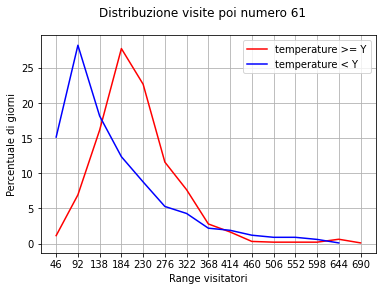

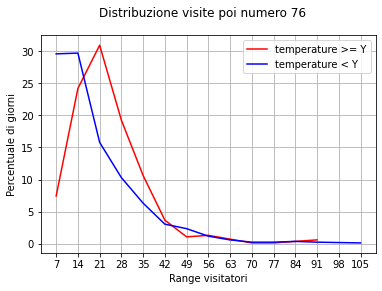

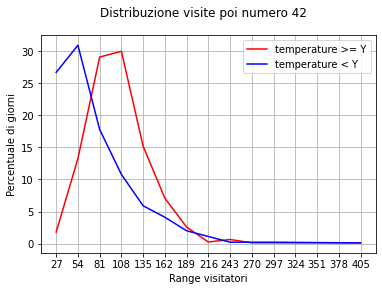

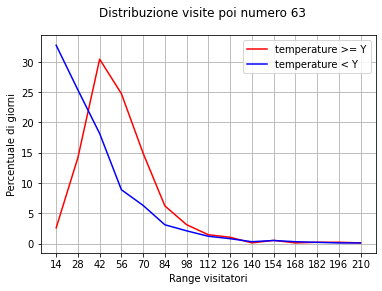

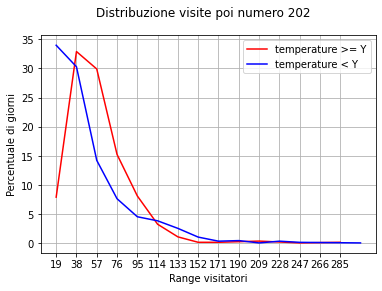

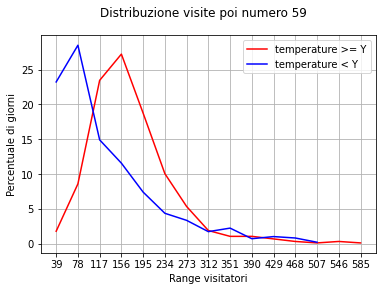

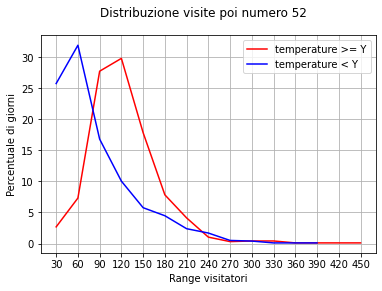

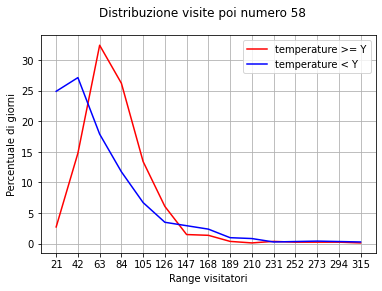

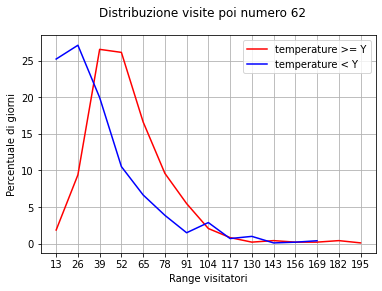

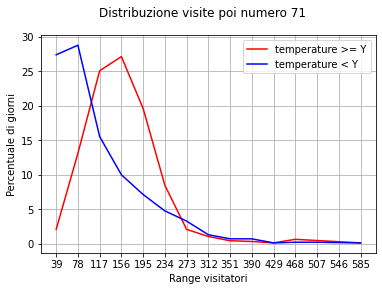

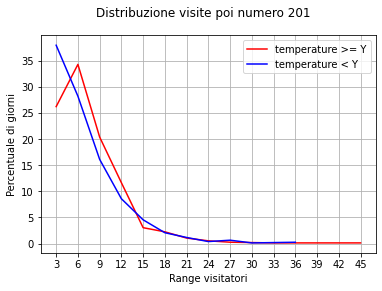

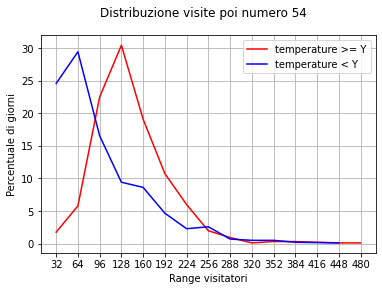

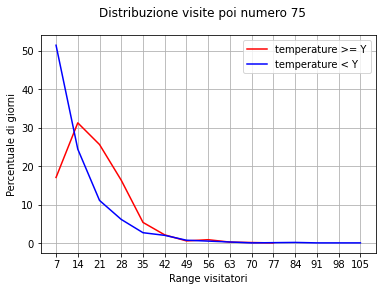

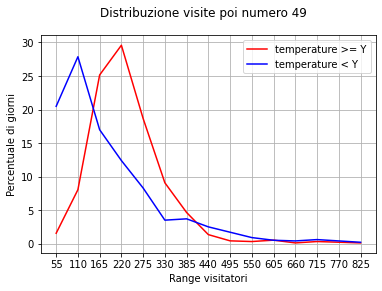

In [35]:
import matplotlib.pyplot as plt

list_poi = data_vc.map(lambda x: x[3]).distinct().collect()

daily_visitors = data_vc.map(lambda x: ((x[3],x[2].split(' ')[0]), 1))\
                            .reduceByKey(lambda a,b: a+b)

over_Y, under_Y = splitTemp(temp_day, mean_temp)

for poi in list_poi:
    count_daily = daily_visitors.filter(lambda x: x[0][0] == poi)\
                                        .map(lambda x: (x[0][1],x[1]))
    max_visitors = count_daily.map(lambda x: x[1]).max()
    min_visitors = count_daily.map(lambda x: x[1]).min()
    
    over_join = count_daily.join(over_Y)
    under_join = count_daily.join(under_Y)
    
    tot_days_over = over_join.count()
    tot_days_under = under_join.count()
    
    over_list = over_join.map(lambda x: (getBucket(x[1][0],max_visitors,min_visitors), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0], x[1] / tot_days_over * 100))\
                            .sortByKey()\
                            .collect()

    under_list = under_join.map(lambda x: (getBucket(x[1][0],max_visitors,min_visitors), 1))\
                            .reduceByKey(lambda a,b: a+b)\
                            .map(lambda x: (x[0], x[1] / tot_days_under * 100))\
                            .sortByKey()\
                            .collect()
    
    bucket = max(int(max_visitors/number_bucket), 1)
    
    visitors_over = [ x[1] for x in over_list]
    visitors_under = [ x[1] for x in under_list]
    bucket_over = [ x[0]*bucket  for x in over_list]
    bucket_under = [ x[0]*bucket  for x in under_list]

    x_labels = range(0, max_visitors,bucket)
    plt.xticks(x_labels)
        
    plt.suptitle('Distribuzione visite poi numero {}'.format(poi))
    plt.xlabel('Range visitatori')
    plt.ylabel('Percentuale di giorni')
    plt.grid()
    plt.plot(bucket_over,visitors_over,color='r', label = 'temperature >= Y')
    plt.plot(bucket_under,visitors_under,color='b', label = 'temperature < Y')
    plt.legend()
    
    plt.show()
